# Project: Medical appointment - no show analysis 

## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#metadata">Metadata definition</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>



<a id='intro'></a>
## Introduction

A patient not showing up for a prescheduled medical appointment is a waste of resources. It not only results in idle time of the physician but as well as all support staff. That time could have been better utilized by catering another patient who needs attention if instead of "no show", the appointment would have been cancelled beforehand.

<a id='metadata'></a>
## Metadata
Documentation at https://www.kaggle.com/joniarroba/noshowappointments/home provides metadata information about the fields in data file. I include them in this notebook for reference purposes during the course of this project

* PatientID - Identification of the patient
* AppointmentID - Unique identification of each appointment
* Gender - Allowabe values F or M. There is more data for female patients (please see below)
* ScheduleDay - The day somebody called and requested for appointment
* AppoinmentDay - The day of appointment
* Age - Age of the patient
* Neighborhood - Where the appointment takes place (not where the patient resides)
* Scholarship - Allowable values are 0 or 1. Additional ref: https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia
* Hipertension - Allowable values are - 0 or 1
* Diabetes - Allowable values are - 0 or 1
* Handcap - Disability status of the patient. Allowable values are 0,1,2,3,4
* SMS_received - 1 or more messages sent to the patient
* No-show: Allowable values are True (missed appointment) or False (fulfilled appointment

In [111]:
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

appt_df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
# Examine sample data
appt_df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [112]:
appt_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


<a id='wrangling'></a>
## Data Wrangling



### General Properties

Data file contains data at the granularity level of date, individual patient and in the neighbourhood in which they were serviced. Rather than focusing on individual pateint information it is useful to rollup (aggregate) the data at higher level of granularity for analytical purposes. For example, one of metric value of interest is calculating the percentage of "no-show" situations.

Initial observation shows us:

* Appointment date contains "datetime" data but the time component is always 00:00:00. So if we can't compute mean wait time (difference between ScheduledDays and AppointmentDay) in hours
* As per the metadata appointment day should always be equal to or greater than scheduled day.
* Handicap column has 5 values 0, 1-4

In [113]:
# Unique values of gender field to make sure that it has nothing other than 'F' & 'M'
appt_df['Gender'].unique()

array(['F', 'M'], dtype=object)

In [114]:
# Count of female and male patients in the data file
appt_df['Gender'].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

### Data Cleansing

* Look for duplicates. There are additional cleasing steps which are outlined below.
    * Confirm that appointment date is always greater than equal to scheduled date
    * Check for null values
    * Check for duplicate records
    * Examine values in age field
    * Examine the values in handicap field

Cleansing is accompanied with 

* Rolling up data at higher level for better analysis
* Enrich data with computed fields

In [115]:
# Check for duplicated records
appt_df.duplicated().sum() == 0


True

<b>No duplcate record found</b>

In [116]:
appt_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [117]:
len(appt_df.query('Age > 100').index.tolist())

7

Lowest age is -1 while highest age is 115. I plan to remove all records with age <= 0. While it is possible to have patient with age = 115, I find it logical to remove all records where age > 100. Also, we have two few appointment data for people who are more than 100 years old.

In [118]:
# Investigate schedule date
# Since both these fields are in YYYY-MM-DDTHH:MI:SSTZ format they can be compared using string comparison
# I will convert them to datetime fields later 

idx = \
    appt_df \
        .assign(ScheduledDay=appt_df['ScheduledDay'] \
                .apply(lambda x: x[:10])) \
        .assign(AppointmentDay=appt_df['AppointmentDay'] \
                .apply(lambda x: x[:10])) \
        .query('ScheduledDay > AppointmentDay').index
len(idx)

5

I find that there are <b>5</b> records for which appointment date is before scheduled date. They appear to be data entry errors.

In [119]:
appt_df = appt_df.query("Age > 0 and Age < 100")

<b>Deleted records having value in "age" column outside the range </b>

In [120]:
len(appt_df.index)

106976

In [121]:
appt_df.drop(index=idx, inplace=True)

In [122]:
len(appt_df.index)

106971

<b>Identified 5 records have been deleted</b>

In [123]:
appt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106971 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         106971 non-null float64
AppointmentID     106971 non-null int64
Gender            106971 non-null object
ScheduledDay      106971 non-null object
AppointmentDay    106971 non-null object
Age               106971 non-null int64
Neighbourhood     106971 non-null object
Scholarship       106971 non-null int64
Hipertension      106971 non-null int64
Diabetes          106971 non-null int64
Alcoholism        106971 non-null int64
Handcap           106971 non-null int64
SMS_received      106971 non-null int64
No-show           106971 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 12.2+ MB


<b>No null value found</b>

### Change to dataframe for ease of analysis

1. Patient ID shows up in exponential format. This data type will be changed to string format.
2. There are two fields - ScheduledDay & AppoitmentDay. These two will be converted to data type "datetime". It will help to do any date/time related analysis. I also store the dates in string format of YYYY-MM-DD for display purposes.
4. Change no_show, handicap, scholarship, hypertension, diabetes, alcolholism, sms_received fields to boolean
4. New computed field to store the wait time in days (Appointment Date - Scheduled Date). The data type will be integer.
5. Convert all column names to lower case for uniformity. Also replace "-" to underscore in column names


In [124]:
appt_df['AppointmentDay'].value_counts()

2016-06-06T00:00:00Z    4528
2016-05-16T00:00:00Z    4448
2016-05-30T00:00:00Z    4359
2016-06-08T00:00:00Z    4356
2016-05-09T00:00:00Z    4351
2016-06-01T00:00:00Z    4350
2016-05-11T00:00:00Z    4347
2016-06-07T00:00:00Z    4264
2016-05-12T00:00:00Z    4233
2016-05-17T00:00:00Z    4226
2016-05-18T00:00:00Z    4220
2016-05-02T00:00:00Z    4214
2016-06-02T00:00:00Z    4203
2016-05-10T00:00:00Z    4177
2016-05-31T00:00:00Z    4156
2016-05-03T00:00:00Z    4127
2016-05-05T00:00:00Z    4112
2016-05-19T00:00:00Z    4107
2016-05-04T00:00:00Z    4047
2016-06-03T00:00:00Z    3976
2016-05-13T00:00:00Z    3885
2016-05-24T00:00:00Z    3876
2016-05-06T00:00:00Z    3791
2016-05-25T00:00:00Z    3768
2016-05-20T00:00:00Z    3707
2016-04-29T00:00:00Z    3104
2016-05-14T00:00:00Z      39
Name: AppointmentDay, dtype: int64

Among all dates of services total number of appointments of 2016-05-14 appears to be unreasonably low. I decided to keep this date as removal of date to result in discontinuity of data.

In [125]:
# Change all column names to lower case and replace dash by underscore.
# Dictionary of column names which needs special handling for converting them to snake case
new_column_names = {'PatientId': 'patient_id', 
                    'AppointmentID': 'appointment_id', 
                    'ScheduledDay': 'scheduled_day',
                    'AppointmentDay': 'appointment_day',
                    'Handcap': 'handicap',
                    'Hipertension': 'hypertension'
                   }

appt_df.columns = [new_column_names[x] if x in new_column_names else x.lower().replace('-','_')  \
                   for x in appt_df.columns]


appt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106971 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         106971 non-null float64
appointment_id     106971 non-null int64
gender             106971 non-null object
scheduled_day      106971 non-null object
appointment_day    106971 non-null object
age                106971 non-null int64
neighbourhood      106971 non-null object
scholarship        106971 non-null int64
hypertension       106971 non-null int64
diabetes           106971 non-null int64
alcoholism         106971 non-null int64
handicap           106971 non-null int64
sms_received       106971 non-null int64
no_show            106971 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 12.2+ MB


In [126]:
# Convert scheduleday to datetime field
appt_df['scheduled_day'] = pd.to_datetime(
    appt_df.scheduled_day.apply(lambda x: x.replace('T', ' ').replace('Z', ' ')), 
    format='%Y-%m-%d %H:%M:%S', 
    utc=True)

In [127]:
# Convert appointmentday to datetime field
appt_df['appointment_day'] = pd.to_datetime(
    appt_df.appointment_day.apply(lambda x: x.replace('T', ' ').replace('Z', ' ')), 
    format='%Y-%m-%d %H:%M:%S', 
    utc=True)

In [128]:
# Change patientID datatype to string
appt_df['patient_id'] = appt_df['patient_id'].apply(lambda x: re.sub(r'\.0{1,}$','',str(x)))
appt_df['no_show'] = appt_df.no_show.apply(lambda x: True if x == 'Yes' else False)
# Most probably handicaps field indicates degree of disability. For analysis purpose I make this field boolean
# along with few other fields
for c in ['scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received']:
    appt_df[c] = appt_df[c].apply(lambda x: False if x == 0 else True)


In [129]:
# Store date time fields just as date without time component
appt_df['scheduled_date'] = pd.DatetimeIndex(appt_df.scheduled_day).normalize()
appt_df['appointment_date'] = pd.DatetimeIndex(appt_df.appointment_day).normalize()
# Compute wait days as difference of days between appointment date and scheduled date
appt_df['wait_days'] = (appt_df.appointment_date - appt_df.scheduled_date).apply(
    lambda x: int(x / np.timedelta64(1, 'D')))
appt_df['appt_day_of_week'] = appt_df['appointment_date'].dt.weekday_name
appt_df['schedule_day_of_week'] = appt_df['scheduled_date'].dt.weekday_name
appt_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 106971 entries, 0 to 110526
Data columns (total 19 columns):
patient_id              106971 non-null object
appointment_id          106971 non-null int64
gender                  106971 non-null object
scheduled_day           106971 non-null datetime64[ns, UTC]
appointment_day         106971 non-null datetime64[ns, UTC]
age                     106971 non-null int64
neighbourhood           106971 non-null object
scholarship             106971 non-null bool
hypertension            106971 non-null bool
diabetes                106971 non-null bool
alcoholism              106971 non-null bool
handicap                106971 non-null bool
sms_received            106971 non-null bool
no_show                 106971 non-null bool
scheduled_date          106971 non-null datetime64[ns, UTC]
appointment_date        106971 non-null datetime64[ns, UTC]
wait_days               106971 non-null int64
appt_day_of_week        106971 non-null object
schedule

In [130]:
np.sort(appt_df['appointment_date'].apply(lambda x: x.strftime("%Y-%m-%d")).unique())

array(['2016-04-29', '2016-05-02', '2016-05-03', '2016-05-04',
       '2016-05-05', '2016-05-06', '2016-05-09', '2016-05-10',
       '2016-05-11', '2016-05-12', '2016-05-13', '2016-05-14',
       '2016-05-16', '2016-05-17', '2016-05-18', '2016-05-19',
       '2016-05-20', '2016-05-24', '2016-05-25', '2016-05-30',
       '2016-05-31', '2016-06-01', '2016-06-02', '2016-06-03',
       '2016-06-06', '2016-06-07', '2016-06-08'], dtype=object)

The data file contains approximately 1 month's data excluding all information of weekends (Saturday & Sunday). This means data is too small to do seasonality analysis e.g. whether number of no-shows related to specific months of the year. 


In [131]:
# Explore day of the week information of appointment days
appt_df[['appointment_date', 'appt_day_of_week']].drop_duplicates().sort_values(by=['appointment_date'])

,appointment_date,appt_day_of_week
0,2016-04-29 00:00:00+00:00,Friday
3295,2016-05-02 00:00:00+00:00,Monday
3235,2016-05-03 00:00:00+00:00,Tuesday
3310,2016-05-04 00:00:00+00:00,Wednesday
3332,2016-05-05 00:00:00+00:00,Thursday
3330,2016-05-06 00:00:00+00:00,Friday
3445,2016-05-09 00:00:00+00:00,Monday
3236,2016-05-10 00:00:00+00:00,Tuesday
3485,2016-05-11 00:00:00+00:00,Wednesday
3329,2016-05-12 00:00:00+00:00,Thursday


Data file doesn't have any weekend data.

Missing weekend data can be because of the reason that clinics operate only on week days or the work file is a sample of actual data available in Kaggle.

<a id='eda'></a>
## Exploratory Data Analysis

To gain insight, this dataset is used to compute few base levels metrics
* Mean wait days - number of days before getting medical attention
* % missed appointment (no shows)

Missed appointment is the main foxus area of the data file. Analyzing data I will try to determine - which feature(s) affect no show scenarios. Precisely I will try to investigate -
* Whether gender has any influence on on-show scenario
* Impact of medical condition (diabetes) & gender on no-show % 
* Whether higher wait day implies higher no-show %
* Influence of gender and wait day on no-show


### Mean wait days

In [132]:
appt_df['wait_days'].median()

4.0

In [133]:
appt_df.wait_days.mean()

10.167363117106506

In [134]:
appt_df.wait_days.describe()

count    106971.000000
mean         10.167363
std          15.263905
min           0.000000
25%           0.000000
50%           4.000000
75%          14.000000
max         179.000000
Name: wait_days, dtype: float64

Apart from finding the mean and median values, I decide look at the distribution of wait time. A histogram and a box-whisker plot of wait day values follow.

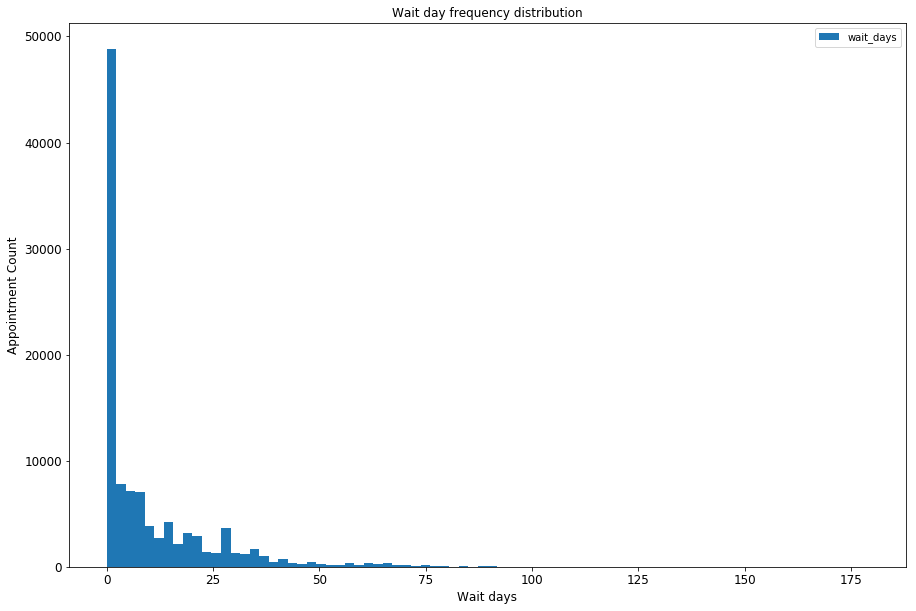

In [135]:

ax = appt_df.wait_days.plot.hist(title="Wait day frequency distribution", 
                                 figsize=(15,10), 
                                 legend=True, 
                                 fontsize=12, 
                                 bins=80);
ax.set_xlabel("Wait days", fontsize=12)
ax.set_ylabel("Appointment Count", fontsize=12);


Next is a box plot of wait times across all days plotted as box-whisker plot. The histogram above shows the distribution has a long right tail. That is emphasized by the box plot which shows the outliers and the fact that median being close to first quartile instead of being in the middle. Presence of outliers is expected to influence the mean value. So I will eliminate the outliers.

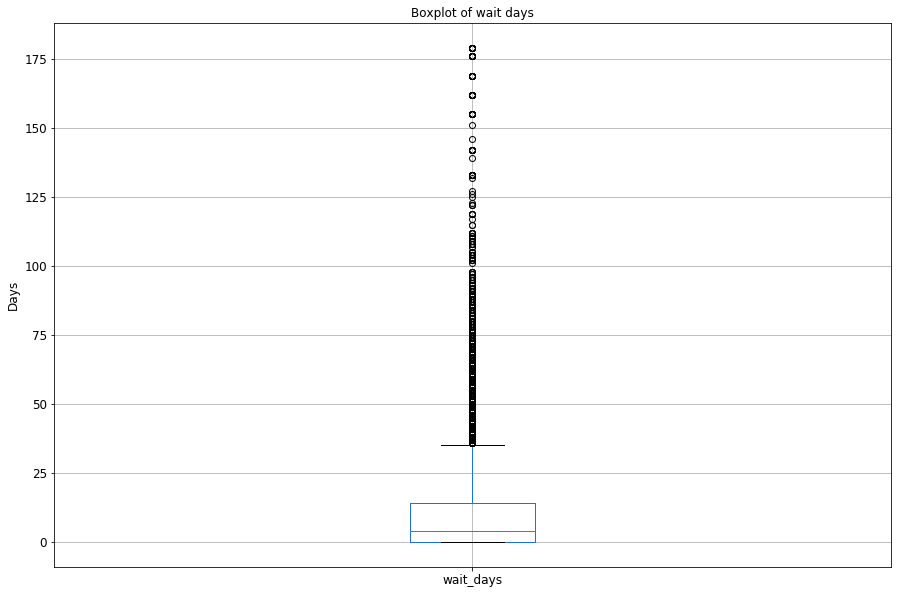

In [136]:
# Analyze the distribution of wait days using box plot
ax = \
appt_df.assign(all_days = 'All')[['all_days', 'wait_days']].boxplot(
    figsize=(15,10), 
    fontsize=12);

plt.title("Boxplot of wait days");
ax.set_ylabel("Days", fontsize=12);

In [137]:

print("Number of records in original data frame: " + str(len(appt_df.index.values.tolist())))
mean_wait_days = appt_df.wait_days.mean()
stddev_wait_days = appt_df.wait_days.std()
# Use 3 sigma rule
cleansed_appt_df = appt_df.query("abs(wait_days - %f) <= (3.0 * %f)" % (mean_wait_days, stddev_wait_days))
print ("Number of records in cleansed data frame: " + str(len(cleansed_appt_df.index.values.tolist())))
cleansed_appt_df.wait_days.mean()


Number of records in original data frame: 106971
Number of records in cleansed data frame: 104383


8.645957675100352

I re-calculated mean after eliminating the outliers. Presence of outliers was influencing mean adversely. New mean is 8.66 days. This indicates that on <b>an average a patient has to wait for 8.66 before getting care.</b>

In [138]:
gender_agg_df = appt_df[['gender','patient_id']]\
.groupby('gender')\
.agg({'patient_id': 'count'})\
.rename(columns={'patient_id': 'patient_count_by_gender'})\
.reset_index()

gender_agg_df


,gender,patient_count_by_gender
0,F,70106
1,M,36865


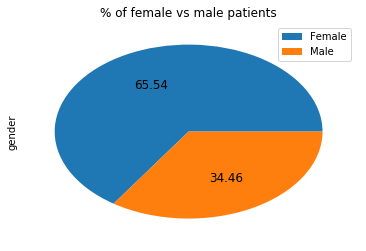

In [139]:

f, axes = plt.subplots()
ax = \
appt_df.gender.value_counts(normalize=True).plot(
    kind='pie', 
    autopct='%.2f', 
    legend=True,
    title="% of female vs male patients", 
    fontsize=12,
    labels=['','']
)
ax.legend(['Female', 'Male'])
plt.show()



It shows that there is signficantly more female patients compared to male. It doesn't indicate that anything is wrong but it is an observation that can be made from the given data set.

<b>Next is overall % of no-shows.</b>

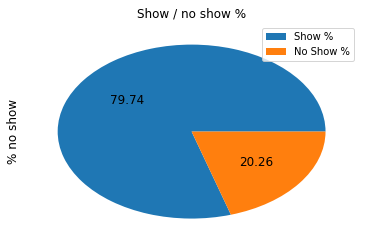

In [146]:

f, axes = plt.subplots()
ax = \
appt_df.no_show.value_counts(normalize=True).plot(
    kind='pie', 
    autopct='%.2f', 
    legend=True,
    title="Show / no show %", 
    fontsize=12,
    labels=['','']
)
ax.legend(['Show %', 'No Show %'])
ax.set_ylabel("% no show", fontsize=12);
plt.show()


<b>20% of appointments result in no-show</b>

<b>Gender & no-show %</b>

[Text(0,0,'Female'), Text(0,0,'Male')]

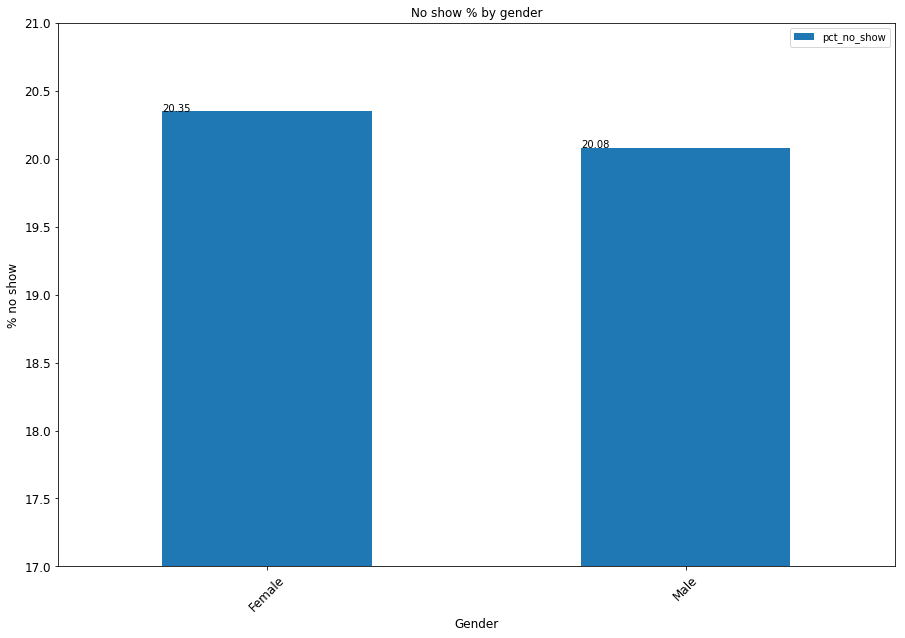

In [141]:
# Group by gender
gender_appt_agg_df = appt_df[['no_show', 'gender', 'patient_id']] \
    .groupby(['no_show', 'gender']) \
    .agg({'patient_id': 'count'}) \
    .reset_index() \
    .rename(columns={'patient_id': 'appt_count_by_gender'}) \
    .merge(gender_agg_df, left_on='gender', right_on='gender')

gender_appt_agg_df = \
    gender_appt_agg_df.assign(pct_of_that_gender= \
                                  round(gender_appt_agg_df.appt_count_by_gender * 100.0 /
                                        gender_appt_agg_df.patient_count_by_gender, 2))

ax = \
    gender_appt_agg_df.query('no_show == True')[['gender', 'pct_of_that_gender']] \
        .rename(columns={'pct_of_that_gender': 'pct_no_show'}) \
        .set_index('gender').plot.bar(
        title='No show % by gender',
        figsize=(15, 10),
        legend=True,
        fontsize=12
    )

# Adjust y axis start value so that 
ax.set_ylim(17, 21)
ax.set_xlabel("Gender", fontsize=12)
ax.set_ylabel("% no show", fontsize=12);

for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))

ax.set_xticklabels(['Female', 'Male'], rotation=45)


<b>The visualization shows that no-show scenarios are little higher for female patients as compared to male patients</b>

<b>Effect of existing medical condition (diabetes) & gender on no-show</b>

Now I look for patients having medical condition like diabetes. Goal is to find whether existence of such a medical condition influnce no show %. Combined features like gender & diabetes is analyzed here.

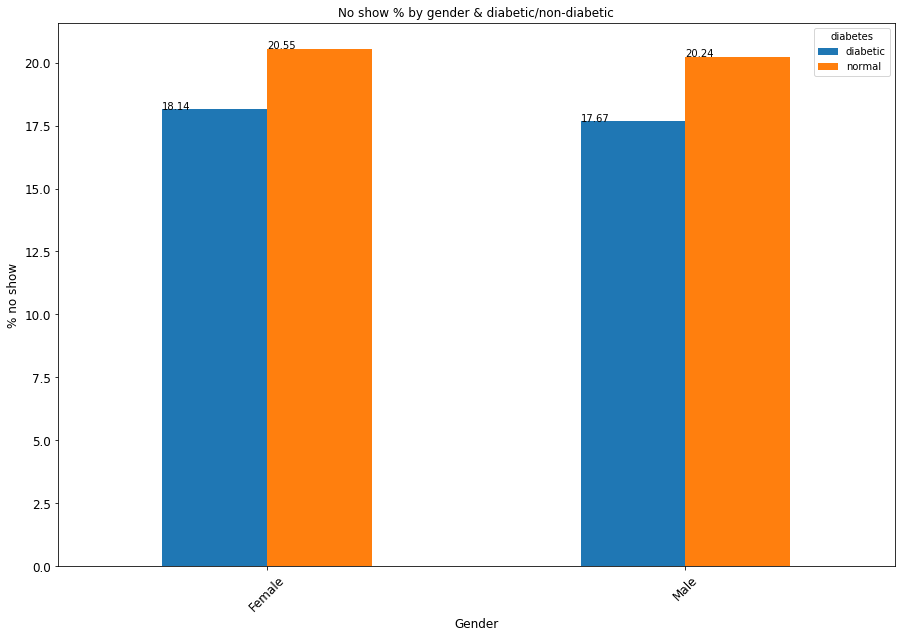

In [142]:
gender_diabetic_df = \
    appt_df[['gender', 'diabetes', 'patient_id']] \
        .groupby(['gender', 'diabetes']) \
        .agg({'patient_id': 'count'}) \
        .rename(columns={'patient_id': 'appt_cnt'}) \
        .reset_index()

gender_diabetic_missed_df = \
    appt_df[['no_show', 'gender', 'diabetes', 'patient_id']] \
        .query("no_show == True") \
        .groupby(['gender', 'diabetes']) \
        .agg({'patient_id': 'count'}) \
        .rename(columns={'patient_id': 'missed_appt_cnt'}) \
        .reset_index() \
        .merge(gender_diabetic_df, left_on=['gender', 'diabetes'], right_on=['gender', 'diabetes'])

gender_diabetic_missed_df = \
    gender_diabetic_missed_df.assign(
        pct_missed=round(gender_diabetic_missed_df.missed_appt_cnt * 100 / gender_diabetic_df.appt_cnt, 2)
    )

gender_diabetic_missed_df['diabetes'] = gender_diabetic_missed_df.diabetes.apply(
    lambda x: 'diabetic' if x == True else 'normal')

diabetic_df = \
    pd.pivot_table(
        gender_diabetic_missed_df[['gender', 'diabetes', 'pct_missed']], \
        index=['gender'],
        columns='diabetes',
        values='pct_missed',
        fill_value=0) \
        .reset_index()[['gender', 'diabetic', 'normal']] \
        .set_index('gender')

ax = \
    diabetic_df \
        .plot.bar(
        figsize=(15, 10),
        legend=True,
        fontsize=12,
        title='No show % by gender & diabetic/non-diabetic'
    );

ax.set_xlabel("Gender", fontsize=12)
ax.set_ylabel("% no show", fontsize=12);
ax.set_xticklabels(['Female', 'Male'], rotation=45)

for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))


After including diabetes feature, the visualization shows that no show % shows noticable decrease of missed apppointment for diabetic patients compared to non-diabetic patients. One reason may be that patients already diagnosed with diabetes are more careful in keeping the appointments rather than missing it.

No show scenarios are lowest for diabetic males.

<b>Next is the analysis of the impact of wait days on missed appointments</b>

In [143]:
appt_df[['wait_days', 'no_show', 'gender', 'patient_id']].query('no_show == True')[['gender', 'wait_days', 'patient_id']]\
.groupby(['gender', 'wait_days'])\
.agg({'patient_id': 'count'})\
.reset_index()['wait_days'].describe()

count    202.000000
mean      55.683168
std       40.680023
min        0.000000
25%       25.000000
50%       50.000000
75%       75.000000
max      179.000000
Name: wait_days, dtype: float64

Value of "wait days" is very widely distributed. It ranges from 0 to 179 day. To study the impact of wait days on missed appointment I divide it into several bins. Bins are not of equal size. For wait days 0 through 4, I have created a bin per day. This primarily because data file contains large number of appointments with wait days between 0 and 4. 


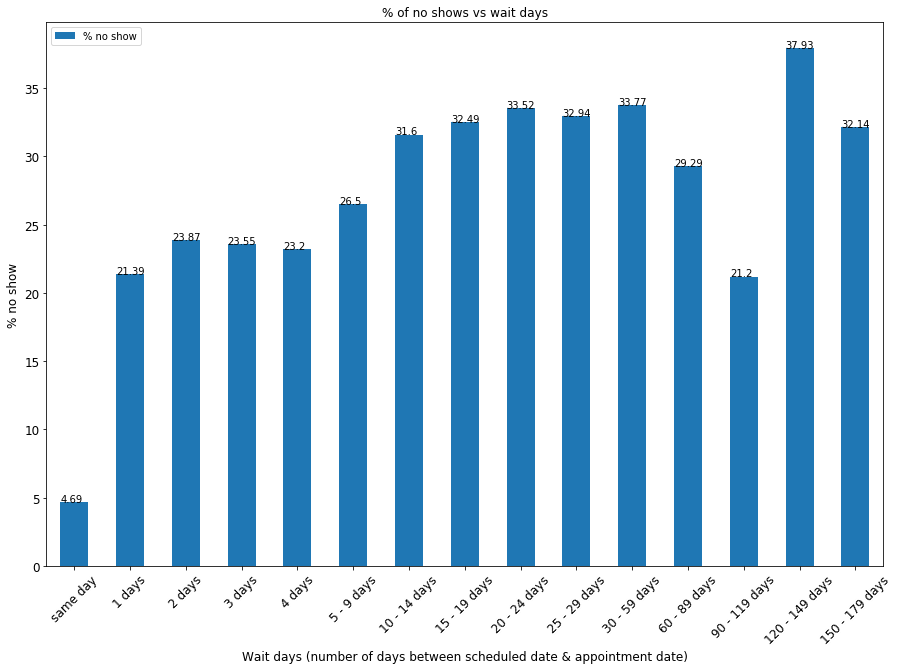

In [144]:
"""
Split up wait_days metrics into several bins
"""


def wait_day_bin(w):
    if w == 0:
        return "same day"
    if w <= 4:
        return "%d days" % w
    elif w >= 5 and w <= 29:
        lower_bound = int(w / 5) * 5
        upper_bound = (int(w / 5) + 1) * 5 - 1
    else:
        lower_bound = int(w / 30) * 30
        upper_bound = (int(w / 30) + 1) * 30 - 1
    return "%d - %d days" % (lower_bound, upper_bound)


appt_df['wait_day_bin'] = appt_df.wait_days.apply(lambda x: wait_day_bin(x))

gender_wait_day_df = \
    appt_df[['wait_day_bin', 'no_show', 'gender', 'sms_received', 'patient_id']] \
        .groupby(['wait_day_bin', 'no_show', 'gender', 'sms_received']) \
        .agg({'patient_id': 'count'}) \
        .rename(columns={'patient_id': 'appt_cnt'}) \
        .reset_index()

agg_wait_days_df = \
    gender_wait_day_df[['wait_day_bin', 'no_show', 'appt_cnt']] \
        .groupby(['wait_day_bin', 'no_show']) \
        .agg({'appt_cnt': 'sum'}) \
        .reset_index()

agg_wait_days_df['no_show'] = agg_wait_days_df.no_show.apply(lambda x: 'no_show' if x == True else 'show')

pivoted_df = \
    pd.pivot_table(
        agg_wait_days_df,
        index=['wait_day_bin'],
        columns='no_show',
        values='appt_cnt',
        fill_value=0) \
        .reset_index()[['wait_day_bin', 'no_show', 'show']]

pivoted_df = pivoted_df.assign(total_appt_cnt=pivoted_df.no_show + pivoted_df.show)
pivoted_df = pivoted_df.assign(pct_missed_appt=round(pivoted_df.no_show * 100 / pivoted_df.total_appt_cnt, 2))

# Get distinct values of all bins for wait_day column
all_bins = []
for i in range(0, 180):
    s = wait_day_bin(i)
    if s not in all_bins:
        all_bins.append(s)

# Defined custom sort order for bin column
pivoted_df['wait_day_bin'] = pd.Categorical(pivoted_df['wait_day_bin'], all_bins)

ax = \
    pivoted_df.sort_values(by=['wait_day_bin'])[['wait_day_bin', 'pct_missed_appt']] \
        .set_index('wait_day_bin') \
        .plot.bar(
        figsize=(15, 10),
        legend=True,
        title='% of no shows vs wait days',
        fontsize=12
    );

ax.set_xlabel("Wait days (number of days between scheduled date & appointment date)", fontsize=12)
ax.set_ylabel("% no show", fontsize=12);
ax.legend(['% no show'], loc='upper left')

for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))

ax.set_xticklabels(all_bins, rotation=45);


The above visualization highlights several interesting facts. For same day appointment, no show percentage is only 4.67% compared to overall 20%. For appointments having 1 or more days wait time, % no show increases almost montonically. There is some exception to this trend e.g. 90-110 days bucket. That may be because of small data volume for appointments in this bin.

<b>Influence of SMS received on no-show percentage</b>


Another feature to be introduced here is the effect of sms_received. To study this effect I will include sms_received column along-with wait days.

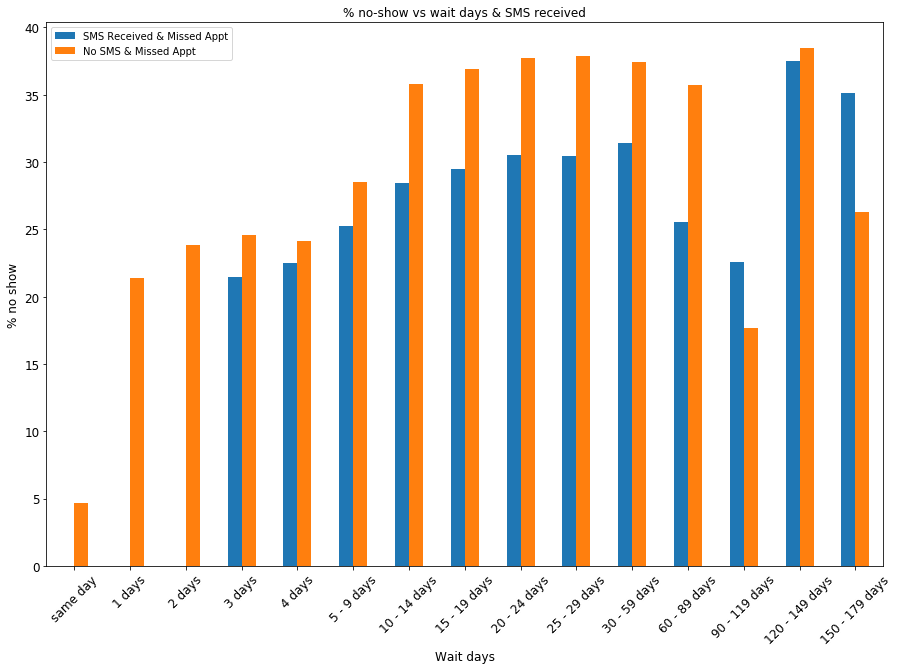

In [145]:
agg_wait_days_df = \
    gender_wait_day_df[['wait_day_bin', 'sms_received', 'no_show', 'appt_cnt']] \
        .groupby(['wait_day_bin', 'sms_received', 'no_show']) \
        .agg({'appt_cnt': 'sum'}) \
        .reset_index()

agg_wait_days_df['no_show'] = agg_wait_days_df.no_show.apply(lambda x: 'no_show' if x == True else 'show')

pivoted_df = \
    pd.pivot_table(
        agg_wait_days_df,
        index=['wait_day_bin', 'sms_received'],
        columns=['no_show'],
        values='appt_cnt',
        fill_value=0) \
        .reset_index()[['wait_day_bin', 'sms_received', 'no_show', 'show']]

pivoted_df = pivoted_df.assign(total_appt_cnt=pivoted_df.no_show + pivoted_df.show)
pivoted_df = pivoted_df.assign(pct_missed_appt=pivoted_df.no_show * 100 / pivoted_df.total_appt_cnt)

sms_df = pivoted_df[['wait_day_bin', 'sms_received', 'pct_missed_appt']].query('sms_received == True') \
    [['wait_day_bin', 'pct_missed_appt']].rename(columns={'pct_missed_appt': 'sms_missed_appt'})
no_sms_df = pivoted_df[['wait_day_bin', 'sms_received', 'pct_missed_appt']].query('sms_received == False') \
    [['wait_day_bin', 'pct_missed_appt']].rename(columns={'pct_missed_appt': 'no_sms_missed_appt'})

combined_df = sms_df.merge(no_sms_df, left_on='wait_day_bin', right_on='wait_day_bin', how='outer')

combined_df['wait_day_bin'] = pd.Categorical(combined_df['wait_day_bin'], all_bins)

ax = \
    combined_df.sort_values(by=['wait_day_bin'])[['wait_day_bin', 'sms_missed_appt', 'no_sms_missed_appt']] \
        .set_index('wait_day_bin') \
        .plot.bar(
        figsize=(15, 10),
        legend=True,
        fontsize=12,
        title='% no-show vs wait days & SMS received'
    );

ax.set_xlabel("Wait days", fontsize=12)
ax.set_ylabel("% no show", fontsize=12)
ax.legend(['SMS Received & Missed Appt', 'No SMS & Missed Appt']);

ax.set_xticklabels(all_bins, rotation=45);


The visualization above shows:

* There was no SMS received for any of the missed appointment with 0 - 2 days
* Starting from wait day = 3, SMS received has very high influence on % no show. % of missed appointment decreases several percent points when SMS is received. SMS tends to act as a great reminder specially when appointment is 4 or more days awa.
* There is exception to rule for 90-119 day bucket but that may be because of small volume of data for such appointments.
    

<a id='conclusions'></a>
## Conclusions

During cleansing and transformation of data, I observe the following.

1. Medical no-show data spanned across almost a month and total record count after cleansing is 106971. Everyday has approximately 3000-4000 appointment data with exception of 2016-05-14 which has only 39 entries. It seems like large of appoinment data didn't get captured for that day. A plot of appointment count by day would have raised more questions than answers because of incomplete data on 2016-05-14
2. Appoinment data was only for weekdays. One possibility can be the clinics operate only on week. Other possibility is lack of completeness of collected data. If the clinics operated over the weekend, then having no show data over the weekend will be useful to compare no-show on weekends vs week days.
3. Appointment day field was lacking hours of the day. Not only that restricts wait day (difference between scheduled & appointment date) to be calculated in days (instead of hours), it also limits the ability to plot data to look for busiest hours.
4. Age of the patients has some noise. Few patients have extraordinary high value in age fields (e.g. 115) and incorrect age (e.g. -1). Quite a few records have age = 0. Ideally representing age in years and months would have been helpful specially for new borns with age < 1 year. For exploratory analysis I had removed records 
5. Major portion of medical appoinment data belonged to female patients. The ratio between male and female patient appointment count is 35:65. While this is a possibility that female patients are more health aware and hence contribute more to total appoinment, it is worth verifying that all male patients data are getting collected. Otherwise collected data willl not be representative of the population.
6. Collected appointment data spans for little more than a month. It would have been useful to see the same for the complete year so that I could probe it for seasonality analysis.
7. Hanicap column was an integer field instead of boolean. It had 0-4 distinct values. I converted it to boolean assuming handicap = 0 indicates no handicap while anything other than 0 indicates handicap.

As female patient appointment count is significantly more, I have used % values so that comparison across gender makes sense. First I study the relationship of no-show by gender. No show % by gender is not hugley different from overall no-show percent though male no-show % is observed to little lower than female counterparts. Inclusion of a medical condition like diabetes" is observed to lower the no-show percent value for both genders. It may be because of patients with known ailments like diabetes tend not to be careful about their health and hence their appointments.

Wait day appeared to me as a useful metric. Wait day is the number of days between scehduled date and appointment data. I study the relationship of % of no-show with wait day. No show incidents tend to increase monotonically except for wait days falling between 90-111 days ramge. Presence of very small number of appointment with wait days between 90-111 days may have been the reason behind the dip in no-show %. Same day appointments  tend to have very small no-show scenario. Intuitively it makes sense as same day appointment may be for scenarios which require urgent attention.

SMS is used for reminder of appointment. Use of SMS tends to bring down missed appointment for all wait day buckets. Again intuitively this observation makes sense. 

None of these findings indicate any cause-effect relationship as these are purely observational based on data coming from the file. Also, there is scope for augmenting these studies with other useful parameters like patient's age, social welfare status etc.

